# A transformer with both encoder and decoder. 

### Intuitively, encoders "understand and interpret", while decoders "write and describe". In file Transformer_with_frozen_conv_1.ipynb, we opted for only using encoder: Our goal is timeseries regression (in the sense that we are looking to create one singular value as the target) and not timeseries prediction (In the sense that we are looking to create a new timeseries), so there was no need for us to implement a decoder to "create a new timeseries in sequence". However, it is a fact that our target value is the sum up a new timeseries, so, we now investigate in using autoregression with decoder to generate a new timeseries and then sum its time steps up. It is unclear if this will help at all. 

## Import and preparations

In [25]:
import sys, importlib
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
import copy
import time

sys.path.append("../")
from proj_mod import training, data_processing, visualization
importlib.reload(training);
importlib.reload(data_processing);
importlib.reload(visualization);

In [2]:
#Only run this cell if needed. AMD gpus might need this. 
from dotenv import load_dotenv
import os

load_dotenv("../dotenv_env/deep_learning.env")

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True" # To, possibly fix memory leak issues. 

print(os.environ.get("HSA_OVERRIDE_GFX_VERSION"))

ModuleNotFoundError: No module named 'dotenv'

In [3]:
device=(torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
print(f"Using device {device}")

Using device cuda


## Data preparations 

### Load time id order

In [4]:
list_time=np.load("../processed_data/recovered_time_id_order.npy")

### Load timeseries 

In [5]:
df_RV_ts=pd.read_parquet("../processed_data/book_RV_ts_60_si.parquet")

### Load target 

In [6]:
df_target=pd.read_csv("../raw_data/kaggle_ORVP/train.csv")
df_target["row_id"]=df_target["stock_id"].astype(int).astype(str)+"-"+df_target["time_id"].astype(int).astype(str)
df_target

,stock_id,time_id,target,row_id
0,0,5,0.004136,0-5
1,0,11,0.001445,0-11
2,0,16,0.002168,0-16
3,0,31,0.002195,0-31
4,0,62,0.001747,0-62
...,...,...,...,...
428927,126,32751,0.003461,126-32751
428928,126,32753,0.003113,126-32753
428929,126,32758,0.004070,126-32758
428930,126,32763,0.003357,126-32763


### Create datasets

In [7]:
time_split_list=data_processing.time_cross_val_split(list_time=list_time,n_split=1,percent_val_size=10,list_output=True)
train_time_id,test_time_id=time_split_list[0][0],time_split_list[0][1]

train_dataset=training.RVdataset(time_id_list=train_time_id,ts_features=["sub_int_RV"],tab_features=["emb_id"],df_ts_feat=df_RV_ts,df_target=df_target)
test_dataset=training.RVdataset(time_id_list=test_time_id,ts_features=["sub_int_RV"],tab_features=["emb_id"],df_ts_feat=df_RV_ts,df_target=df_target)

In fold 0 :

Train set end at 8117 .

Test set start at 15516 end at 10890 .



/home/machine2/Desktop/Realized_Volatility_Prediction_-erdos_deeplearning-/NNetwork/../proj_mod/training.py:396: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tab_copy["sub_int_num"]=np.nan
/home/machine2/Desktop/Realized_Volatility_Prediction_-erdos_deeplearning-/NNetwork/../proj_mod/training.py:396: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tab_copy["sub_int_num"]=np.nan


## The model (Only autoregression, no teacher forcing)

### As mentioned, we will use autoregression with decoder to create a new timeseries. One thing to note is that we will NOT be implementing teacher forcing with masked decoder for now. Teacher forcing is a powerful tool, but the context is not the same: We do not have another timeseries to as ground truth to train toward, so we have "nothing to hide" with the masking. Instead of teacher forcing, we are using the loss calculated with the actual target (future RV) and the aoturegression created timeseries to train. This might not even be possible: I foresee memory explosion since, normally, autoregression is done with no_grad() context and can take a huge amount of memory (since grad will keep the computation graph, which is HUGE if we are doing autoregression). But we will see. 

### Create the dataloaders

In [7]:
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=512,shuffle=True, num_workers=4, pin_memory=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=512,shuffle=True, num_workers =4, pin_memory=True)

### Create components needed

In [9]:
ts_emb_dim=32
n_diff=2
ts_dim=n_diff+1

pos_embedder=training.pos_emb_cross_attn(length=60,ts_dim=ts_dim,emb_dim=ts_emb_dim,dropout=0.2,num_heads=4,keep_mag=True).to(device=device)

ts_encoder_ff_layer=[
    nn.Linear(in_features=ts_emb_dim,out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64,out_features=ts_emb_dim)
]

ts_decoder_ff_layer=[
    nn.Linear(in_features=ts_emb_dim,out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64,out_features=ts_emb_dim)
]

output_ff=nn.Sequential(
    nn.Linear(in_features=ts_emb_dim,out_features=1)
).to(device=device)

/home/ycoeusz/.pyenv/versions/deep_learning_3_11_8/lib/python3.11/site-packages/torch/nn/modules/module.py:1353: UserWarning: expandable_segments not supported on this platform (Triggered internally at /pytorch/c10/hip/HIPAllocatorConfig.h:30.)
  return t.to(


### Create model

In [ ]:
trans_encoder_decoder_model=training.encoder_decoder_autoregressionOnly(
    pos_emb_model=pos_embedder,
    output_feedforward=output_ff,
    encoder_dropout=0.2,
    decoder_dropout=0.2,
    encoder_feedforward_list=ts_encoder_ff_layer,
    decoder_feedforward_list=ts_decoder_ff_layer,
    n_diff=n_diff,
    encoder_layer_num=2,
    decoder_layer_num=2,
    input_scaler=10000,
    ts_emb_dim=ts_emb_dim,
    encoder_num_heads=4,
    decoder_num_heads=4,
    encoder_keep_mag=True,
    decoder_keep_mag=True,
).to(device=device)

In [11]:
import torch.optim as optim

optimizer = optim.AdamW(trans_encoder_decoder_model.parameters(), lr=1e-3)

scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode="min",factor=0.5,patience=5,min_lr=1e-7)

# Loss tracking
train_loss = []
val_loss = []

In [12]:
from torchinfo import summary
summary(trans_encoder_decoder_model)

Layer (type:depth-idx)                                       Param #
encoder_decoder_autoregression                               --
├─frozen_diff_conv: 1-1                                      --
│    └─Conv1d: 2-1                                           (2)
├─pos_emb_cross_attn: 1-2                                    --
│    └─Linear: 2-2                                           128
│    └─Embedding: 2-3                                        1,920
│    └─MultiheadAttention: 2-4                               3,168
│    │    └─NonDynamicallyQuantizableLinear: 3-1             1,056
│    └─LayerNorm: 2-5                                        64
├─ModuleList: 1-3                                            --
│    └─ts_encoder: 2-6                                       --
│    │    └─MultiheadAttention: 3-2                          4,224
│    │    └─LayerNorm: 3-3                                   64
│    │    └─ModuleList: 3-4                                  4,192
│    │    └─LayerN

### Training loop

### As of now, the model has issue with memory: it is using all the 12 GB of my AMD GPU. I need to look deeper in attempt to fix this. According to my reading, since grad context keeps all the computation graphs, and autoregression may have HUGE graph, this is kinda expected. The only way, for now, I can see to bypass this is doing teacher training and doing autoregression under no_grad() context. But we will see. 

In [13]:
training.reg_training_loop_rmspe(
    optimizer=optimizer,
    model=trans_encoder_decoder_model,
    train_loader=train_loader,
    val_loader=test_loader,
    ot_steps=20,
    report_interval=5,
    n_epochs=200,
    list_train_loss=train_loss,
    list_val_loss=val_loss,
    device=device,
    eps=1e-8,
    scheduler=scheduler)

OutOfMemoryError: HIP out of memory. Tried to allocate 28.00 MiB. GPU 0 has a total capacity of 11.98 GiB of which 0 bytes is free. Of the allocated memory 10.77 GiB is allocated by PyTorch, and 886.30 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## The Model (With only teacher forcing, using the current timeseries as ground_target) 

### The reason we went, first to the autoregression only method was that there was no ground target, but what if we just use the current sequence as the ground target in the decoder? Intuitively this is asking the cross attention layers: For the time steps in my query (the ground target), how can I adjust the query with the values (encoder output), based on the attention of keys (encoder output) on the query. 

### A comment on masking

The formula for masked attention is $Attention(Q,K,V,M)=softmax(QK^T/\sqrt{d_Q}\ + \ M)\ V$ (where $d_Q$ is the number of row of $Q$, e.g the length of the timeseries in our context, and $M$ stands for the mask). 

In our case, we are using the "casual mask": (example of dimension length of Query timeseries being 3) 

$$M:=\begin{pmatrix}
    0 & -\inf & -\inf \\ 
    0 & 0 & -\inf \\ 
    0 & 0 & 0 
\end{pmatrix}$$

For sake of understanding, consider following example in full: 

$$X:=\begin{pmatrix}
    1 & 0 \\ 
    0.5 & 1 \\ 
    0 & 1.5 
\end{pmatrix}$$

For context, in above, the "length of timeseries $X$" is the number of row of $X$, i.e. 3. And the "dimension of each time step of $X$" is number of column of $X$ i.e. 2. 
We will use a pythonic notation $X[i]$ to indicate the $i^th$ row of $X$ for $0\leq i\leq 2$. 

We take $Q=K=V:=X$ (so we are doing a self attention), and have that (we are setting $\sqrt{d_Q}$ to be 1, for simplicity): 

$$QK^T=\begin{pmatrix}
    1 & 0.5 & 0 \\ 
    0.5 & 1.25 & 1.5 \\ 
    0 & 1.5 & 2.25 
\end{pmatrix}$$ 

And so 

$$QK^T+M=\begin{pmatrix}
    1 & -\inf & -\inf \\ 
    0.5 & 1.25 & -\inf \\ 
    0 & 1.5 & 2.25 
\end{pmatrix}$$

Then we apply the softmax on this matrix, recall definition of the soft max: 

$$softmax(x_{i}):=\frac{e^{x_{i}}}{\sum\limits_{j\in \text{ index set}} e^{x_{j}}}$$ 

We should get something close to: 

$$Attn=\begin{pmatrix}
    1 & 0 & 0 \\ 
    0.32 & 0.68 & 0 \\ 
    0.06 & 0.21 & 0.73 
\end{pmatrix}\ V = 
\begin{pmatrix}
    1\ * \ X[0] \\ 
    0.32\ * \ X[0]\ + \ 0.68\ * \ X[1] \\ 
    0.06\ * \ X[0]\ + \ 0.21\ * \ X[1]\ + \ 0.73\ * \ X[2]
\end{pmatrix}$$

Intuitively, $Attn[i]$ is only determined by $X[j]$ for $0\leq j\leq i$ for all $i$. This makes it so that "Attention with casual masking can not look into the future for current step". 

### Create dataloaders 

In [8]:
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=512,shuffle=True, num_workers=4, pin_memory=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=512,shuffle=True, num_workers =4, pin_memory=True)

### Create components 

In [9]:
ts_emb_dim=32
n_diff=2
ts_dim=n_diff+1

pos_embedder=training.pos_emb_cross_attn(length=60,ts_dim=ts_dim,emb_dim=ts_emb_dim,dropout=0.2,num_heads=4,keep_mag=True).to(device=device)

ts_encoder_ff_layer=[
    nn.Linear(in_features=ts_emb_dim,out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64,out_features=ts_emb_dim)
]

ts_decoder_ff_layer=[
    nn.Linear(in_features=ts_emb_dim,out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64,out_features=ts_emb_dim)
]

output_ff=nn.Sequential(
    nn.Linear(in_features=ts_emb_dim,out_features=1)
).to(device=device)

### Create model

In [10]:
trans_encoder_decoder_tf_model=training.encoder_decoder_teacherforcing(
    pos_emb_model=pos_embedder,
    output_feedforward=output_ff,
    encoder_dropout=0.2,
    decoder_dropout=0.2,
    encoder_feedforward_list=ts_encoder_ff_layer,
    decoder_feedforward_list=ts_decoder_ff_layer,
    n_diff=n_diff,
    encoder_layer_num=2,
    decoder_layer_num=2,
    input_scaler=10000,
    ts_emb_dim=ts_emb_dim,
    encoder_num_heads=4,
    decoder_num_heads=4,
    encoder_keep_mag=True,
    decoder_keep_mag=True,
    return_sum=True
).to(device=device)

In [11]:
import torch.optim as optim

optimizer = optim.AdamW(trans_encoder_decoder_tf_model.parameters(), lr=1e-3)

scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode="min",factor=0.5,patience=5,min_lr=1e-7)

# Loss tracking
train_loss = []
val_loss = []

In [12]:
from torchinfo import summary
summary(trans_encoder_decoder_tf_model)

Layer (type:depth-idx)                                       Param #
encoder_decoder_teacherforcing                               --
├─frozen_diff_conv: 1-1                                      --
│    └─Conv1d: 2-1                                           (2)
├─pos_emb_cross_attn: 1-2                                    --
│    └─Linear: 2-2                                           128
│    └─Embedding: 2-3                                        1,920
│    └─MultiheadAttention: 2-4                               3,168
│    │    └─NonDynamicallyQuantizableLinear: 3-1             1,056
│    └─LayerNorm: 2-5                                        64
├─ModuleList: 1-3                                            --
│    └─ts_encoder: 2-6                                       --
│    │    └─MultiheadAttention: 3-2                          4,224
│    │    └─LayerNorm: 3-3                                   64
│    │    └─ModuleList: 3-4                                  4,192
│    │    └─LayerN

### Training loop 

In [13]:
training.reg_training_loop_rmspe(
    optimizer=optimizer,
    model=trans_encoder_decoder_tf_model,
    train_loader=train_loader,
    val_loader=test_loader,
    ot_steps=20,
    report_interval=5,
    n_epochs=200,
    list_train_loss=train_loss,
    list_val_loss=val_loss,
    device=device,
    eps=1e-8,
    scheduler=scheduler)

A new best validation loss at epoch  1  with validation loss of  tensor(0.2360, device='cuda:0') .
At  24.368682146072388  epoch  1 has training loss  tensor(0.2746, device='cuda:0')  and validation loss  tensor(0.2360, device='cuda:0') .

A new best validation loss at epoch  2  with validation loss of  tensor(0.2356, device='cuda:0') .
A new best validation loss at epoch  3  with validation loss of  tensor(0.2337, device='cuda:0') .
A new best validation loss at epoch  4  with validation loss of  tensor(0.2316, device='cuda:0') .
At  126.59550452232361  epoch  5 has training loss  tensor(0.2489, device='cuda:0')  and validation loss  tensor(0.2322, device='cuda:0') .

At  254.07837462425232  epoch  10 has training loss  tensor(0.2474, device='cuda:0')  and validation loss  tensor(0.2334, device='cuda:0') .

At epoch 10, learning rate has been updated from 0.001 to 0.0005, reloading previous best model weights from epoch 4 ...

Previous best model weights reloaded, training continues .

OrderedDict([('frozen_conv.frozen_conv.weight',
              tensor([[[-1.,  1.]]], device='cuda:0')),
             ('pos_emb.ts_proj.weight',
              tensor([[ 0.5243, -0.2829,  0.1898],
                      [ 0.1887,  0.1524, -0.3744],
                      [-0.4206, -0.2532,  0.3629],
                      [-0.0923,  0.0470,  0.2774],
                      [-0.3300, -0.5331, -0.2996],
                      [-0.0594, -0.2248, -0.1744],
                      [-0.2332, -0.2448, -0.3765],
                      [ 0.3739,  0.1150,  0.2523],
                      [ 0.2041, -0.5227, -0.2917],
                      [-0.3198,  0.3190,  0.1713],
                      [-0.1335,  0.1406,  0.0728],
                      [-0.3787,  0.2856, -0.1774],
                      [ 0.3807, -0.4102, -0.2325],
                      [ 0.1481, -0.0115, -0.1855],
                      [ 0.0272,  0.3295,  0.0888],
                      [-0.5111, -0.2753, -0.0785],
                      [ 0.5766, -0.0617,

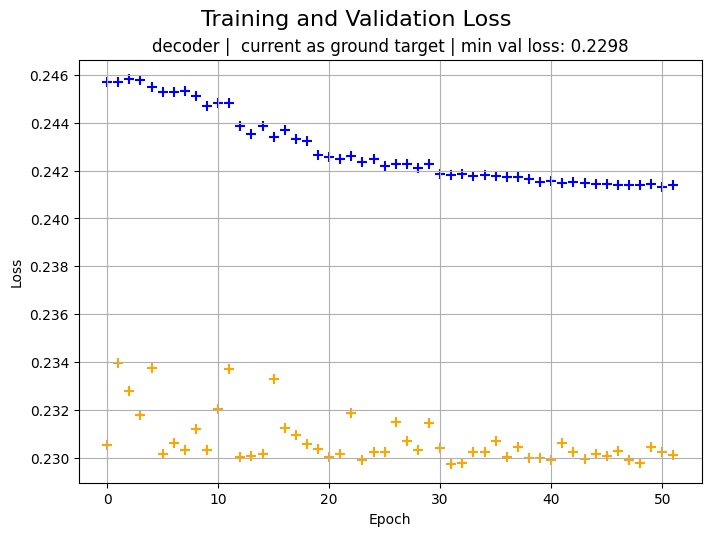

In [16]:
from proj_mod import visualization

train_loss_cut = train_loss[10:]
val_loss_cut = val_loss[10:]

vis_dict={("decoder","current as ground target"):{"train_loss": train_loss_cut,"val_loss": val_loss_cut}}
visualization.training_plots(vis_dict, fig_width=7)

#### The above model has already beaten all (native) rnn based model, I think adding more layers of encoder and decoder might improve it, let's try. 

We will keep using the dataloader and components of the above model. 

### Create model

In [10]:
trans_encoder_decoder_tf_model=training.encoder_decoder_teacherforcing(
    pos_emb_model=pos_embedder,
    output_feedforward=output_ff,
    encoder_dropout=0.2,
    decoder_dropout=0.2,
    encoder_feedforward_list=ts_encoder_ff_layer,
    decoder_feedforward_list=ts_decoder_ff_layer,
    n_diff=n_diff,
    encoder_layer_num=4, #Changed
    decoder_layer_num=4, #Changed
    input_scaler=10000,
    ts_emb_dim=ts_emb_dim,
    encoder_num_heads=4,
    decoder_num_heads=4,
    encoder_keep_mag=True,
    decoder_keep_mag=True,
    return_sum=True
).to(device=device)

In [11]:
import torch.optim as optim

optimizer = optim.AdamW(trans_encoder_decoder_tf_model.parameters(), lr=1e-3)

scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode="min",factor=0.5,patience=5,min_lr=1e-7)

# Loss tracking
train_loss = []
val_loss = []

In [12]:
from torchinfo import summary
summary(trans_encoder_decoder_tf_model)

Layer (type:depth-idx)                                       Param #
encoder_decoder_teacherforcing                               --
├─frozen_diff_conv: 1-1                                      --
│    └─Conv1d: 2-1                                           (2)
├─pos_emb_cross_attn: 1-2                                    --
│    └─Linear: 2-2                                           128
│    └─Embedding: 2-3                                        1,920
│    └─MultiheadAttention: 2-4                               3,168
│    │    └─NonDynamicallyQuantizableLinear: 3-1             1,056
│    └─LayerNorm: 2-5                                        64
├─ModuleList: 1-3                                            --
│    └─ts_encoder: 2-6                                       --
│    │    └─MultiheadAttention: 3-2                          4,224
│    │    └─LayerNorm: 3-3                                   64
│    │    └─ModuleList: 3-4                                  4,192
│    │    └─LayerN

### Training loop

In [13]:
en4de4_weight_dict=training.reg_training_loop_rmspe(
    optimizer=optimizer,
    model=trans_encoder_decoder_tf_model,
    train_loader=train_loader,
    val_loader=test_loader,
    ot_steps=20,
    report_interval=5,
    n_epochs=200,
    list_train_loss=train_loss,
    list_val_loss=val_loss,
    device=device,
    eps=1e-8,
    scheduler=scheduler)

A new best validation loss at epoch  1  with validation loss of  tensor(0.2409, device='cuda:0') .
At  44.422447204589844  epoch  1 has training loss  tensor(0.3097, device='cuda:0')  and validation loss  tensor(0.2409, device='cuda:0') .

A new best validation loss at epoch  2  with validation loss of  tensor(0.2336, device='cuda:0') .
A new best validation loss at epoch  4  with validation loss of  tensor(0.2336, device='cuda:0') .
At  229.51333856582642  epoch  5 has training loss  tensor(0.2512, device='cuda:0')  and validation loss  tensor(0.2386, device='cuda:0') .

A new best validation loss at epoch  6  with validation loss of  tensor(0.2315, device='cuda:0') .
A new best validation loss at epoch  8  with validation loss of  tensor(0.2313, device='cuda:0') .
A new best validation loss at epoch  10  with validation loss of  tensor(0.2309, device='cuda:0') .
At  460.97391963005066  epoch  10 has training loss  tensor(0.2481, device='cuda:0')  and validation loss  tensor(0.2309, d

## The model with above as base and adjusted with learned embedding of stock id by multiplication 

Since we are sure that the native encoder with decoder transformer beat the native rnn based models, we will adjust them with the stock id and, hopefully, get improve result. 

### Prepare data

#### Load in emb_id

In [14]:
RV_tab=pd.read_csv("../processed_data/RV_by_row_id.csv")
RV_tab["stock_id"]=RV_tab["row_id"].apply(lambda x: x.split("-")[0])
RV_tab["time_id"]=RV_tab["row_id"].apply(lambda x: x.split("-")[1])
RV_tab

,time_id,RV,row_id,stock_id
0,5,0.002185,93-5,93
1,11,0.001205,93-11,93
2,16,0.001461,93-16,93
3,31,0.001693,93-31,93
4,62,0.001296,93-62,93
...,...,...,...,...
428927,32751,0.002337,104-32751,104
428928,32753,0.001500,104-32753,104
428929,32758,0.002272,104-32758,104
428930,32763,0.001949,104-32763,104


In [15]:
# Creates tabular data, most specifically 'emb_id'
unique_ids = sorted(RV_tab['stock_id'].unique())
id_to_emb = {stock_id: i for i, stock_id in enumerate(unique_ids)}
RV_tab['emb_id'] = RV_tab['stock_id'].map(id_to_emb)
RV_tab

,time_id,RV,row_id,stock_id,emb_id
0,5,0.002185,93-5,93,105
1,11,0.001205,93-11,93,105
2,16,0.001461,93-16,93,105
3,31,0.001693,93-31,93,105
4,62,0.001296,93-62,93,105
...,...,...,...,...,...
428927,32751,0.002337,104-32751,104,7
428928,32753,0.001500,104-32753,104,7
428929,32758,0.002272,104-32758,104,7
428930,32763,0.001949,104-32763,104,7


#### Recreate datasets and dataloaders 

In [40]:
time_split_list=data_processing.time_cross_val_split(list_time=list_time,n_split=1,percent_val_size=10,list_output=True)
train_time_id,test_time_id=time_split_list[0][0],time_split_list[0][1]

train_dataset=training.RVdataset(time_id_list=train_time_id,ts_features=["sub_int_RV"],tab_features=["emb_id"],df_ts_feat=df_RV_ts,df_tab_feat=RV_tab,df_target=df_target)
test_dataset=training.RVdataset(time_id_list=test_time_id,ts_features=["sub_int_RV"],tab_features=["emb_id"],df_ts_feat=df_RV_ts,df_tab_feat=RV_tab,df_target=df_target)

ts_place, id_place=train_dataset.featureplace["sub_int_RV"], train_dataset.featureplace["emb_id"]

In fold 0 :

Train set end at 8117 .

Test set start at 15516 end at 10890 .



In [41]:
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=512,shuffle=True, num_workers=4, pin_memory=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=512,shuffle=True, num_workers =4, pin_memory=True)

# Loss tracking
train_loss = []
val_loss = []

### Create the model

In [42]:
trans_encoder_decoder_tf_model=training.encoder_decoder_teacherforcing(
    pos_emb_model=pos_embedder,
    output_feedforward=output_ff,
    encoder_dropout=0.2,
    decoder_dropout=0.2,
    encoder_feedforward_list=ts_encoder_ff_layer,
    decoder_feedforward_list=ts_decoder_ff_layer,
    n_diff=n_diff,
    encoder_layer_num=4, #Changed
    decoder_layer_num=4, #Changed
    input_scaler=10000,
    ts_emb_dim=ts_emb_dim,
    encoder_num_heads=4,
    decoder_num_heads=4,
    encoder_keep_mag=True,
    decoder_keep_mag=True,
    return_sum=True
).to(device=device)

In [43]:
#Set base model 
base_trans_model=trans_encoder_decoder_tf_model

#Create hidden layer for stock id learned embedding 
from collections import OrderedDict

id_emb_dim=8

id_hidden_dict=OrderedDict([("linear1", nn.Linear(in_features=id_emb_dim, out_features=32),),
                            ("tanh1", nn.Tanh()),
                            ("linear2", nn.Linear(in_features=32, out_features=16)),
                            ("tanh2", nn.Tanh()),
                            ("linear3", nn.Linear(in_features=16, out_features=8)),
                            ("tanh3", nn.Tanh()),
                            ("linear4", nn.Linear(in_features=8,out_features=1))])

id_hidden_layers=nn.Sequential(id_hidden_dict).to(device=device)

#Create the adjustment by multiplication model (notice training.id_learned_embedding_adj_rnn_mtpl still works, we are just using the transformer model in place of the rnn based model). 
transformer_adjusted_model=training.id_learned_embedding_adj_rnn_mtpl(ts_place=ts_place,id_place=id_place, rnn_model=base_trans_model,id_hidden_model=id_hidden_layers,id_input_num=112,emb_dim=id_emb_dim).to(device)

#Create the optimizer and the scheduler 
import torch.optim as optim

optimizer = optim.AdamW(transformer_adjusted_model.parameters(), lr=1e-3)

scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode="min",factor=0.5,patience=5,min_lr=1e-7)

#Show summary
from torchinfo import summary
summary(transformer_adjusted_model)

Layer (type:depth-idx)                                            Param #
id_learned_embedding_adj_rnn_mtpl                                 --
├─Embedding: 1-1                                                  896
├─encoder_decoder_teacherforcing: 1-2                             --
│    └─frozen_diff_conv: 2-1                                      --
│    │    └─Conv1d: 3-1                                           (2)
│    └─pos_emb_cross_attn: 2-2                                    --
│    │    └─Linear: 3-2                                           128
│    │    └─Embedding: 3-3                                        1,920
│    │    └─MultiheadAttention: 3-4                               4,224
│    │    └─LayerNorm: 3-5                                        64
│    └─ModuleList: 2-3                                            --
│    │    └─ts_encoder: 3-6                                       8,544
│    │    └─ts_encoder: 3-7                                       8,544
│    │    └─ts

### Training loop

In [ ]:
transformer_adjusted_weight_dict=training.reg_training_loop_rmspe(
    optimizer=optimizer,
    model=transformer_adjusted_model,
    train_loader=train_loader,
    val_loader=test_loader,
    ot_steps=20,
    report_interval=5,
    n_epochs=200,
    list_train_loss=train_loss,
    list_val_loss=val_loss,
    device=device,
    eps=1e-8,
    scheduler=scheduler)

In [39]:
import sys, importlib
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
import copy
import time

sys.path.append("../")
from proj_mod import training, data_processing, visualization
importlib.reload(training);
importlib.reload(data_processing);
importlib.reload(visualization);